In [1]:
# 02_adoption_modeling.ipynb

# --- manipulating data / manipular la data ---
import pandas as pd, numpy as np

# --- modeling + ML / modelado + ML ---
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score




# --- statistics / estadística ---
from scipy.stats import pearsonr, spearmanr, shapiro, normaltest, mannwhitneyu
import cvxpy as cp
# --- graphs + networks / gráficos + redes ---
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# drawings / diagramas
import schemdraw, schemdraw.elements as elm

# --- config + paths / configuración + rutas ---
import yaml
import joblib
from pathlib import Path

# --- load configuration / cargar configuración ---
cfg = yaml.safe_load(open("../config.yml"))
root = Path.cwd().parent
clean, spatial, stake, tech = (root/cfg["paths"]["clean_data"],
                               root/cfg["paths"]["spatial_data"],
                               root/cfg["paths"]["stakeholders"],
                               root/cfg["paths"]["tech_specs"])

# --- datasets / conjuntos de datos ---
pareto = pd.read_csv(clean/"pareto.csv", sep=cfg["defaults"]["separator"], encoding=cfg["defaults"]["encoding"])
buildings_train = pd.read_csv(clean/"buildings_train.csv", sep=cfg["defaults"]["separator"], encoding=cfg["defaults"]["encoding"])
tech_specs = pd.read_csv(tech/"heating_technologies.csv", sep=cfg["defaults"]["separator"], encoding=cfg["defaults"]["encoding"])
stakeholders = pd.read_csv(stake/"stakeholder_map.csv", sep=cfg["defaults"]["separator"], encoding=cfg["defaults"]["encoding"])

# --- quick sanity check / verificación rápida ---
print("Rows:", { "pareto": len(pareto),
                "buildings_train": len(buildings_train),
                "tech_specs": len(tech_specs),
                "stakeholders": len(stakeholders) })

Rows: {'pareto': 21, 'buildings_train': 55717, 'tech_specs': 4, 'stakeholders': 6}


# DMAIC Six Sigma Methodology / Metodología DMAIC

| Phase | Description | Descripción  | Examples / Ejemplos |
|---------------|------------------|------------------|----------------------|
| **Define / Definir** | Identify the problem, goals, scope, and customer needs. | Identificar el problema, los objetivos, el alcance y las necesidades del cliente. | • Decarbonize heating systems in Madrid / Descarbonizar equipos para calefacción en Madrid <br> • With Pareto Diagnosis forecast paths / Hecho el análisis de Pareto evaluar rutas <br> • Technologies: heat pumps, district heating, gas boilers, biomass boilers / Tecnologías: bombas de calor, calefacción urbana (district heating), calderas de gas, calderas de biomasa <br> • Define Stakeholder / Definir Actores Clave <br> • Align Technology with Stakeholder priorities / Alinear tecnología con las prioridades de Actores Clave |
| **Measure / Medir** | Collect data to understand current performance and establish a baseline. | Recoger datos para entender el rendimiento actual y establecer una línea base. | • Inputs: building-level heating demand, emissions density, income, retrofit_readiness, costs / Valores: Demanda de calefacción, densidad de emisiones, renta, adecuados para actualizar, costes |
| **Analyze / Analizar** | Investigate root causes of defects or inefficiencies using data and diagnostics. | Investigar las causas raíz de los defectos o ineficiencias con datos y diagnóstico. | • Correlations / Correlaciones |
| **Improve / Mejorar** | Develop and implement solutions to eliminate root causes and optimize performance. | Desarrollar e implementar soluciones para eliminar causas raíz y optimizar procesos. | • Simulate adoption scenarios under stakeholder levers / Simular escenarios de implementación bajo aspectos de actores clave |
| **Control / Controlar** | Monitor results, standardize improvements, and prevent regression over time. | Monitorear resultados, estandarizar mejoras y prevenir retrocesos con el tiempo. | • Validate against constraints: budget, infrastructure / Validar respecto a restricciones como presupuestos o infraestructura |

In [2]:
# DMAIC
# Define ) Pareto Districts / Distritos Pareto: Latina, Pte. Vallecas, Carabanchel, Usera, Ciudad Lineal.
target_ids = [10, 13, 12, 11, 15]
target_districts = buildings_train[buildings_train["district_id"].isin(target_ids)]
target_districts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18493 entries, 0 to 55715
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   postal_code                 18493 non-null  int64  
 1   e_surface_m2                18493 non-null  float64
 2   e_pct_surface_heated        18493 non-null  int64  
 3   e_heating_demand_kwh_m2_a   18493 non-null  float64
 4   final_heating_kwh_m2_a      18493 non-null  float64
 5   nonren_co2_heating_kg_m2_a  18493 non-null  float64
 6   e_hotwater_demand_kwh_m2_a  18493 non-null  float64
 7   district_id                 18493 non-null  int64  
 8   renta_bruta_media           18493 non-null  object 
 9   building_co2_kg             18493 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 1.6+ MB


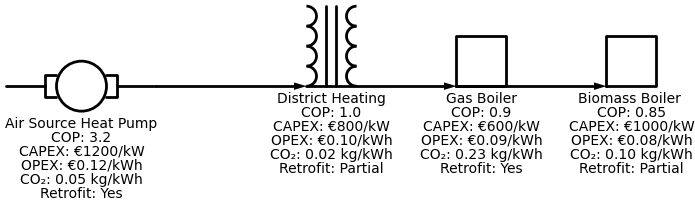

,tech,efficiency_cop,capex_eur_kw,opex_eur_kwh,emissions_kgco2_kwh,retrofit_ready,notes
0,air_source_hp,3.20,1200,0.12,0.05,yes,Most efficient in mild climates; dominant low-...
1,district_heating,1.00,800,0.10,0.02,partial,Depends on grid carbon intensity and network a...
2,gas_boiler,0.90,600,0.09,0.23,yes,Current baseline in most Spanish homes
3,biomass_boiler,0.85,1000,0.08,0.10,partial,Used in rural areas; renewable but emits parti...


In [3]:
# Define) # Technologies: heat pumps, district heating, gas boilers, biomass boilers

with schemdraw.Drawing() as d:
    d.config(fontsize=10)
    # Air Source Heat Pump / Bomba de calor 
    d += elm.Motor().label('Air Source Heat Pump\nCOP: 3.2\nCAPEX: €1200/kW\nOPEX: €0.12/kWh\nCO₂: 0.05 kg/kWh\nRetrofit: Yes', loc='bottom')
    d += elm.Arrow().right()
    # District Heating / 
    d += elm.Transformer().label('District Heating\nCOP: 1.0\nCAPEX: €800/kW\nOPEX: €0.10/kWh\nCO₂: 0.02 kg/kWh\nRetrofit: Partial', loc='bottom')
    d += elm.Arrow().right()
    # Gas Boiler /
    d += elm.Rect().label('Gas Boiler\nCOP: 0.9\nCAPEX: €600/kW\nOPEX: €0.09/kWh\nCO₂: 0.23 kg/kWh\nRetrofit: Yes', loc='bottom')
    d += elm.Arrow().right()
    # Biomass Boiler /
    d += elm.Rect().label('Biomass Boiler \nCOP: 0.85\nCAPEX: €1000/kW\nOPEX: €0.08/kWh\nCO₂: 0.10 kg/kWh\nRetrofit: Partial', loc='bottom')
tech_specs

In [4]:
# Define)  Stakeholders / Actores Clave
stakeholders 

,actor,influence,interest,decision,levers
0,IDAE,High,High,subsidies,mandates
1,Ayuntamiento Madrid,High,High,zoning,district heating infrastructure
2,Housing Coops,Medium,High,retrofit access,collective bargaining
3,Citizens,Low,High,adoption choice,awareness
4,Utilities,High,Medium,grid capacity,tariffs
5,Tech Providers,Medium,Medium,technology cost,supply chain


### Stakeholder / Actores Clave
| actor                | influence | interest | decision_levers                             | comment                                                                 | comentario                                                                 |
|----------------------|-----------|----------|----------------------------------------------|----------------------------------------------------------------------------|----------------------------------------------------------------------------|
| IDAE                 | High      | High     | subsidies, mandates                          | National energy agency. Drives funding and regulation for heating systems. | Agencia nacional de energía. Lidera financiación y regulación de sistemas térmicos. |
| Ayuntamiento Madrid  | High      | High     | zoning, infrastructure rollout               | City government. Controls urban planning and district heating deployment.  | Gobierno municipal. Controla planificación urbana y despliegue de calefacción distrital. |
| Housing Coops        | Medium    | High     | retrofit access, collective bargaining       | Organized residents. Key for scaling retrofits in entire multi-family buildings.  | Residentes organizados. Clave para escalar rehabilitaciones en edificios multifamiliares. |
| Citizens             | Low    | High     | adoption choice, awareness                   | End users. Their choices and awareness shape adoption rates.               | Usuarios finales. Sus decisiones y conciencia determinan las tasas de adopción. |
| Utilities            | High      | Medium   | grid capacity, tariffs                       | Energy providers. Influence infrastructure readiness and operating costs.  | Proveedores energéticos. Influyen en la infraestructura y costes operativos. |
| Tech Providers       | Medium    | Medium   | technology cost, supply chain                | Manufacturers and installers. Affect cost, availability, and deployment.   | Fabricantes e instaladores. Afectan coste, disponibilidad y despliegue. |

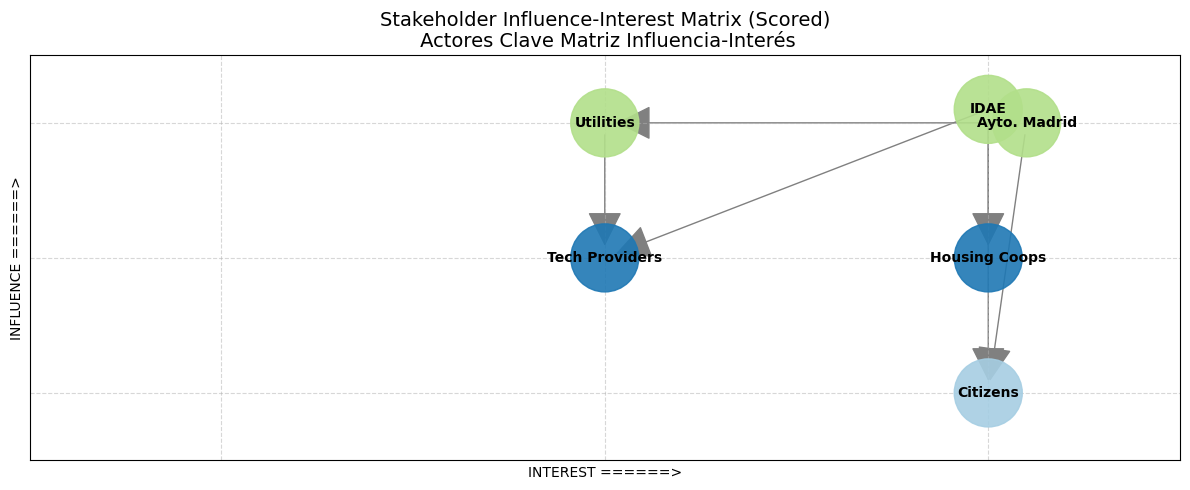

In [5]:
# Define)  Stakeholders Matrix / Matriz de Actores Clave

# Scoring logic /Lógica para asignar puntos
def score_influence(actor):
    if actor in ["IDAE", "Ayto. Madrid", "Utilities"]:
        return 3
    elif actor in ["Housing Coops", "Tech Providers"]:
        return 2
    else:
        return 1

def score_interest(actor):
    if actor in ["Citizens", "Housing Coops", "IDAE", "Ayto. Madrid"]:
        return 3
    elif actor in ["Tech Providers", "Utilities"]:
        return 2
    else:
        return 1

stakeholders = {
    "IDAE": ["subsidies", "mandates"],
    "Ayto. Madrid": ["zoning", "infrastructure rollout"],
    "Housing Coops": ["retrofit access", "collective bargaining"],
    "Citizens": ["adoption choice", "awareness"],
    "Utilities": ["grid capacity", "tariffs"],
    "Tech Providers": ["technology cost", "supply chain"]
}
G = nx.DiGraph()
for actor, levers in stakeholders.items():
    G.add_node(actor,
               influence=score_influence(actor),
               interest=score_interest(actor),
               levers=levers)

edges = [
    ("IDAE", "Housing Coops"),
    ("IDAE", "Citizens"),
    ("IDAE", "Tech Providers"),
    ("Ayto. Madrid", "Citizens"),
    ("Ayto. Madrid", "Utilities"),
    ("Utilities", "Tech Providers")
]
G.add_edges_from(edges)
pos = {
    "IDAE": (3.0, 3.1),
    "Ayto. Madrid": (3.1, 3.0),
    "Housing Coops": (3.0, 2.0),
    "Citizens": (3.0, 1.0),
    "Utilities": (2.0, 3.0),
    "Tech Providers": (2.0, 2.0)
}
color_map = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a"}
node_colors = [color_map[G.nodes[node]['influence']] for node in G.nodes]
plt.figure(figsize=(12, 5))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2400, alpha=0.9)
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=55, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.title("Stakeholder Influence-Interest Matrix (Scored)\n Actores Clave Matriz Influencia-Interés", fontsize=14)
plt.xlabel("INTEREST ======>")
plt.ylabel("INFLUENCE ======>")
plt.xticks([1, 2, 3], ["Low", "Medium", "High"])
plt.yticks([1, 2, 3], ["Low", "Medium", "High"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)
plt.tight_layout()
plt.show()

### Stakeholder Influence-Interest Matrix (Scored)

#### Scoring Logic 
- **Influence (1–3)**: Power to shape outcomes (funding, regulation, infrastructure)
- **Interest (1–3)**: Stake in outcome (exposure to emissions, retrofit cost, adoption impact)

#### Stakeholder Table

| actor                | influence | interest | decision_levers                             | comment                                                                | comentario                                                                 |
|----------------------|-----------|----------|----------------------------------------------|----------------------------------------------------------------------------|----------------------------------------------------------------------------|
| IDAE                 | 3         | 3        | subsidies, mandates                          | National energy agency. Drives funding and regulation.                     | Agencia nacional. Lidera financiación y regulación.                        |
| Ayuntamiento Madrid  | 3         | 3        | zoning, infrastructure rollout               | City government. Controls planning and district heating.                   | Gobierno municipal. Controla planificación y calefacción distrital.       |
| Housing Coops        | 2         | 3        | retrofit access, collective bargaining       | Organized residents. Key for scaling retrofits.                            | Residentes organizados. Clave para rehabilitaciones.                       |
| Citizens             | 1         | 3        | adoption choice, awareness                   | End users. Influence adoption and social norms.                            | Usuarios finales. Influyen en adopción y normas sociales.                  |
| Utilities            | 3         | 2        | grid capacity, tariffs                       | Energy providers. Control infrastructure and pricing.                      | Proveedores energéticos. Controlan infraestructura y tarifas.             |
| Tech Providers       | 2         | 2        | technology cost, supply chain                | Manufacturers/installers. Affect cost and deployment.                      | Fabricantes/instaladores. Afectan coste y despliegue.                      |

#### Influence Network / Red de Influencia

| Section      | Sección            | Content                                                                 | Contenido                                                                 |
|---------------------|-------------------------|-------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **Influence Network (Edges)** | **Red de Influencia (Aristas)** | • IDAE → Housing Coops, Citizens, Tech Providers <br> • Ayuntamiento Madrid → Citizens, Utilities <br> • Utilities → Tech Providers | • IDAE → Cooperativas de Vivienda, Ciudadanos, Proveedores Tecnológicos <br> • Ayuntamiento de Madrid → Ciudadanos, Empresas de Servicios Públicos <br> • Empresas de Servicios Públicos → Proveedores Tecnológicos |
| **Matrix Coordinates** | **Coordenadas de la Matriz** | • X-axis: Interest (1 = Low, 3 = High) <br> • Y-axis: Influence (1 = Low, 3 = High) <br> • Node color: Influence level (light blue = 1, blue = 2, green = 3) <br> • Arrows: Directional influence between actors | • Eje X: Interés (1 = Bajo, 3 = Alto) <br> • Eje Y: Influencia (1 = Baja, 3 = Alta) <br> • Color del nodo: Nivel de influencia (azul claro = 1, azul = 2, verde = 3) <br> • Flechas: Influencia direccional entre actores |
| **Use Cases**       | **Casos de Uso**        | • Prioritize engagement (top-right quadrant = key actors) <br> • Simulate policy scenarios (e.g. IDAE increases subsidies) <br> • Feed dashboard filters and rollout logic | • Priorizar la participación (cuadrante superior derecho = actores clave) <br> • Simular escenarios de política (ej. IDAE aumenta las subvenciones) <br> • Alimentar filtros de panel de control y lógica de despliegue |

In [6]:
# Measure Inputs: building-level heating demand, emissions density, income, retrofit_readiness, costs / Valores: Demanda de calefacción, densidad de emisiones, renta, adecuados para actualizar, costes |

X = target_districts[[
    "e_heating_demand_kwh_m2_a",
    "final_heating_kwh_m2_a",
    "nonren_co2_heating_kg_m2_a",
    "renta_bruta_media"
]]
y = target_districts["building_co2_kg"]

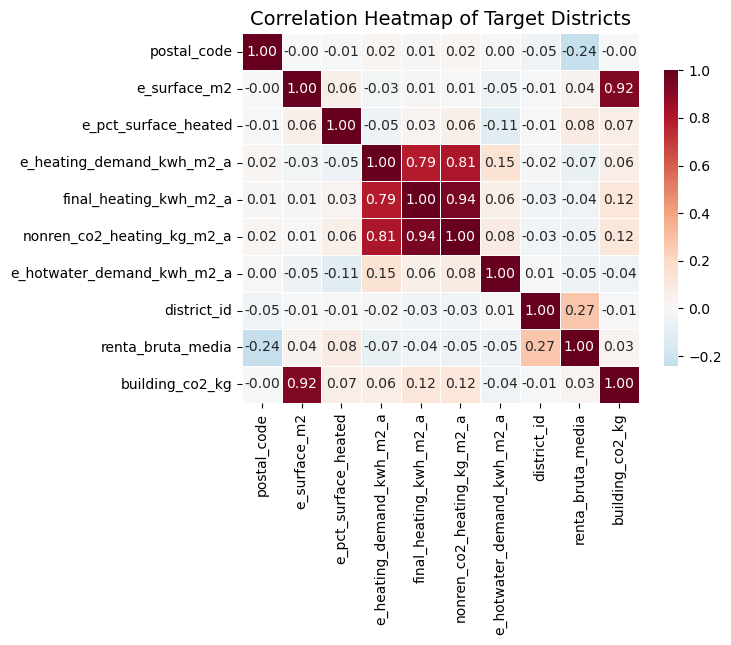

R2 of LinearRegression Model: 0.012693209831755703


In [7]:
# Analyze) Correlations, regression baseline / Correlaciones, prueba con regresión lineal.

corr = target_districts.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            linewidths=0.5, cbar_kws={"shrink":0.8})
plt.title("Correlation Heatmap of Target Districts", fontsize=14)
plt.show()

# First Model / Primer Modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
preds = model.predict(X_test)
print("R2 of LinearRegression Model:", r2_score(y_test, preds))

#### Correlation & Regression Summary / Resumen de Correlaciones y Regresión

| Aspect  | Aspecto  | Findings  | Hallazgos  |
|-------------|--------------|---------------|----------------|
| **Correlation: e_surface_m2 vs. building_co2_kg** | **Correlación: e_surface_m2 vs. building_co2_kg** | Very strong positive correlation (0.92). Larger buildings emit more. Like Moncloa district | Correlación muy fuerte positiva (0.92). Los edificios más grandes emiten más. Pensar en Moncloa |
| **Correlation: final_heating_kwh_m2_a & nonren_co2_heating_kg_m2_a vs. building_co2_kg** | **Correlación: final_heating_kwh_m2_a y nonren_co2_heating_kg_m2_a vs. building_co2_kg** | Moderate correlation (~0.12). Intensity per m² matters, but less than total area. | Correlación moderada (~0.12). La intensidad por m² influye, pero menos que la superficie total. |
| **Correlation: renta_bruta_media vs. emissions** | **Correlación: renta_bruta_media vs. emisiones** | Almost no correlation (0.03). Income alone does not explain CO₂. | Casi sin correlación (0.03). La renta por sí sola no explica el CO₂. |
| **Regression result** | **Resultado de la regresión** | R² = 0.0127 → Model explains only 1.3% of variance. Predictors (intensity, income) insufficient. | R² = 0.0127 → El modelo explica solo el 1.3% de la varianza. Predictores (intensidad, renta) insuficientes. |
| **Consequences** | **Consecuencias** | Cannot rely on district-level regression. Must model at building level where surface area and heating demand dominate. | No se puede confiar en la regresión a nivel de distrito. Se debe modelar a nivel de edificio, donde dominan la superficie y la demanda de calefacción. |
| **Recommendation** | **Recomendación** | Aggregate building-level predictions (e.g., expected CO₂ savings × retrofit probability) to prioritize districts. | Agregar predicciones a nivel de edificio (ej. ahorros esperados de CO₂ × probabilidad de rehabilitación) para priorizar distritos. |
| **Next step (simplified)** | **Próximo paso (simplificado)** | Train a simple GaussianNB classifier for retrofit readiness, then aggregate savings per technology back to districts. | Entrenar un clasificador GaussianNB simple para preparación de rehabilitación y luego agregar ahorros por tecnología a los distritos. |

In [8]:
# --- Feature Engineering / Ingeniería de variables ---
b = buildings_train.copy()

b["pct_heated_frac"] = b["e_pct_surface_heated"].clip(0,100)/100   # heated % / % calefacción
b["annual_heating_kwh"] = b["e_heating_demand_kwh_m2_a"] * b["e_surface_m2"] * b["pct_heated_frac"]  # demand*area / demanda*superficie

# fill CO2 if missing/zero / rellenar CO2 si falta o es 0
mask = b["building_co2_kg"].isna() | (b["building_co2_kg"]==0)
b.loc[mask,"building_co2_kg"] = b.loc[mask,"nonren_co2_heating_kg_m2_a"] * b.loc[mask,"e_surface_m2"] * b.loc[mask,"pct_heated_frac"]

# income to numeric + fillna / renta a numérico + rellenar
b["renta_bruta_media"] = pd.to_numeric(b["renta_bruta_media"], errors="coerce")
b["renta_bruta_media"] = b["renta_bruta_media"].fillna(b["renta_bruta_media"].median())

# label top 1/3 energy or CO2 / etiqueta top 1/3 energía o CO2
kwh_thr, co2_thr = b["annual_heating_kwh"].quantile(0.66), b["building_co2_kg"].quantile(0.66)
b["retrofit_ready"] = ((b["annual_heating_kwh"]>=kwh_thr) | (b["building_co2_kg"]>=co2_thr)).astype(int)

buildings_train = b

| Feature / Variable        | Description                        | Descripción                           |
|---------------------------|-------------------------------------------------------|---------------------------------------------------|
| pct_heated_frac           | Fraction of heated surface (0–1)                      | Fracción de superficie calefactada (0–1)          |
| annual_heating_kwh        | Annual heating demand (kWh) = demand × area × frac    | Demanda anual de calefacción (kWh) = demanda × área × fracción |
| building_co2_kg (filled)  | CO₂ emissions; filled with non‑renewable factor if 0  | Emisiones de CO₂; rellenado con factor no renovable si 0 |
| renta_bruta_media (num)   | Median‑filled numeric income for stability            | Renta media convertida a numérico y rellenada con mediana |
| retrofit_ready (label)    | Binary target: top 1/3 by heating demand or CO₂       | Etiqueta binaria: tercio superior por demanda o CO₂ |

In [9]:
# --- Normality checks / Pruebas de normalidad ---

features = ["e_surface_m2","annual_heating_kwh","building_co2_kg","renta_bruta_media"]
results = []

for col in features:
    data = pd.to_numeric(buildings_train[col], errors="coerce").dropna()
    
    # Shapiro-Wilk test / Prueba de Shapiro-Wilk
    _, p_shapiro = shapiro(data.sample(min(len(data),5000)))  # limit size / limitar tamaño
    
    # D’Agostino-Pearson test / Prueba de D’Agostino-Pearson
    _, p_dagostino = normaltest(data)
    
    # Interpretation / Interpretación
    interp = "Normal / Normal" if (p_shapiro>=0.05 and p_dagostino>=0.05) else "Not normal / No normal"
    
    results.append([col, round(p_shapiro,4), round(p_dagostino,4), interp])

summary = pd.DataFrame(results, columns=["Feature","p_Shapiro","p_DAgostino","Interpretation"])
print(summary)

              Feature  p_Shapiro  p_DAgostino          Interpretation
0        e_surface_m2        0.0          0.0  Not normal / No normal
1  annual_heating_kwh        0.0          0.0  Not normal / No normal
2     building_co2_kg        0.0          0.0  Not normal / No normal
3   renta_bruta_media        0.0          0.0  Not normal / No normal


### Normality Check – Consider Transformations

All key features failed normality tests (p < 0.05).  
→ Apply transformations to reduce skewness and approximate normality:

| Feature              | Suggested Transformation | Transformación sugerida  |
|----------------------|-------------------------------|-------------------------------|
| e_surface_m2         | log1p or sqrt                 | log1p o raíz cuadrada         |
| annual_heating_kwh   | log1p                         | log1p                         |
| building_co2_kg      | log1p                         | log1p                         |
| renta_bruta_media    | Yeo–Johnson / Box–Cox         | Yeo–Johnson / Box–Cox         |

*Note: Re‑test normality after transformation to confirm improvement.*

In [10]:
# --- Transformations / Transformaciones ---
f_log = ["e_surface_m2","annual_heating_kwh","building_co2_kg"]  # log1p / log1p
f_yj  = ["renta_bruta_media"]                                    # Yeo-Johnson / Yeo-Johnson

df = buildings_train[f_log+f_yj].apply(pd.to_numeric, errors="coerce").fillna(buildings_train.median())

# log1p for energy/size / log1p para energía/superficie
df[f_log] = np.log1p(df[f_log])

# Yeo-Johnson for income / Yeo-Johnson para renta
pt = PowerTransformer(method="yeo-johnson")
df[f_yj] = pt.fit_transform(df[f_yj])

# --- Normality re-test / Re-test de normalidad ---
res=[]
for c in df.columns:
    p1 = shapiro(df[c].sample(min(len(df),5000)))[1]   # Shapiro p / p Shapiro
    p2 = normaltest(df[c])[1]                          # D’Agostino p / p D’Agostino
    interp = "Normal / Normal" if (p1>=0.05 and p2>=0.05) else "Not normal / No normal"
    res.append([c, round(p1,4), round(p2,4), interp])

summary = pd.DataFrame(res, columns=["Feature","p_Shapiro","p_DAgostino","Interpretation"])
print(summary)

              Feature  p_Shapiro  p_DAgostino          Interpretation
0        e_surface_m2        0.0          0.0  Not normal / No normal
1  annual_heating_kwh        0.0          0.0  Not normal / No normal
2     building_co2_kg        0.0          0.0  Not normal / No normal
3   renta_bruta_media        0.0          0.0  Not normal / No normal


In [11]:
# --- Spearman correlation / Correlación de Spearman ---
features = ["e_surface_m2","annual_heating_kwh","building_co2_kg","renta_bruta_media"]
for f in features:
    rho,p = spearmanr(buildings_train[f], buildings_train["retrofit_ready"])
    print(f"{f}: rho={rho:.2f}, p={p:.3g}")  # en: correlation strength / es: fuerza de correlación

# --- Mann-Whitney test / Prueba de Mann-Whitney ---
g0 = buildings_train.loc[buildings_train["retrofit_ready"]==0,"annual_heating_kwh"]
g1 = buildings_train.loc[buildings_train["retrofit_ready"]==1,"annual_heating_kwh"]
stat,p = mannwhitneyu(g0,g1,alternative="two-sided")
print(f"Mann-Whitney annual_heating_kwh: U={stat}, p={p:.3g}")  # en: group diff / es: diferencia entre grupos


e_surface_m2: rho=0.66, p=0
annual_heating_kwh: rho=0.78, p=0
building_co2_kg: rho=0.80, p=0
renta_bruta_media: rho=0.08, p=5.41e-75
Mann-Whitney annual_heating_kwh: U=27441712.0, p=0


### Robust Non‑Parametric Analysis / Análisis no paramétrico robusto

**Before / Antes**  
- Normality tests (Shapiro, D’Agostino) rejected normality for all features (p < 0.05).  
- Therefore, parametric correlations were not appropriate.  
- Se rechazó la normalidad en todas las variables → no era adecuado usar correlaciones paramétricas.

**Now with robust methods / Ahora con métodos robustos**  
- Applied **Spearman correlation** (monotonic, non‑parametric).  
- Applied **Mann–Whitney U test** to compare groups (retrofit_ready=0 vs 1).  
- Se aplicó correlación de **Spearman** y prueba **Mann–Whitney U**.

| Feature / Variable     | Spearman ρ | p‑value | Interpretation  |
|------------------------|------------|---------|-------------------------|
| e_surface_m2           | 0.66       | 0.000   | Strong positive / Fuerte positiva |
| annual_heating_kwh     | 0.78       | 0.000   | Very strong positive / Muy fuerte positiva |
| building_co2_kg        | 0.80       | 0.000   | Very strong positive / Muy fuerte positiva |
| renta_bruta_media      | 0.08       | 5.4e‑75 | Weak but significant / Débil pero significativa |

**Mann–Whitney U (annual_heating_kwh)**  
- U = 27,441,712, p = 0.000  
- → Distributions differ significantly between retrofit vs. non‑retrofit groups.  
- → Las distribuciones difieren de forma significativa entre grupos.

**GaussianNB**  
- Is my desired model to use because my features are continuous (surface, kWh, CO2, Income) It assumes normality, which my data doesn’t perfectly meet so either I complement it with non‑parametric checks or compare against tree‑based models.

In [12]:
# --- Transformations / Transformaciones ---
f_log = ["e_surface_m2","annual_heating_kwh","building_co2_kg"]   # log1p / log1p
f_yj  = ["renta_bruta_media"]                                     # Yeo-Johnson / Yeo-Johnson

X = buildings_train[f_log+f_yj].apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())                                          # fillna / rellenar

X[f_log] = np.log1p(X[f_log])                                     # log1p transform / transformación log1p
pt = PowerTransformer(method="yeo-johnson")
X[f_yj] = pt.fit_transform(X[f_yj])                               # Yeo-Johnson / Yeo-Johnson

y = buildings_train["retrofit_ready"]

# --- Train/Test split / División entrenamiento-prueba ---
X_train,X_test,y_train,y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

# --- GaussianNB model / Modelo GaussianNB ---
clf = GaussianNB()
clf.fit(X_train,y_train)

# --- Evaluation / Evaluación ---
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred,digits=3))
print("ROC AUC:", roc_auc_score(y_test,y_proba))

              precision    recall  f1-score   support

           0      0.817     0.979     0.891      8640
           1      0.950     0.643     0.766      5290

    accuracy                          0.851     13930
   macro avg      0.884     0.811     0.829     13930
weighted avg      0.868     0.851     0.844     13930

ROC AUC: 0.9488353068332984


#### GaussianNB Model Evaluation / Evaluación del modelo GaussianNB

##### Classification Report / Informe de clasificación

| Class / Clase | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| 0 (Not ready / No listo) | 0.817 | 0.979 | 0.891 | 8640 |
| 1 (Ready / Listo)        | 0.950 | 0.643 | 0.766 | 5290 |

**Accuracy / Exactitud**: 0.851 (13,930 samples)  
**Macro avg / Promedio macro**: Precision 0.884, Recall 0.811, F1 0.829  
**Weighted avg / Promedio ponderado**: Precision 0.868, Recall 0.851, F1 0.844  
**ROC AUC**: 0.949  

---

##### Explanation 

- **Class 0 (Not ready)**: Very high recall (0.979) → the model almost never mislabels a non‑ready building as ready.  
- **Class 1 (Ready)**: Very high precision (0.950) but lower recall (0.643) → when the model predicts “ready,” it is almost always correct, but it misses some true ready cases.  
- **Overall**: Accuracy is strong (85%), and ROC AUC near 0.95 shows excellent ranking ability.  
- **Implication**: The model is conservative — it prioritizes avoiding false positives. This is useful for policy or investment decisions where targeting only the most certain retrofit candidates is safer.

---

##### Explicación 

- **Clase 0 (No listo)**: Recall muy alto (0.979) → el modelo casi nunca clasifica erróneamente un edificio no listo como listo.  
- **Clase 1 (Listo)**: Precisión muy alta (0.950) pero recall más bajo (0.643) → cuando predice “listo” casi siempre acierta, pero deja escapar algunos casos verdaderamente listos.  
- **Global**: Exactitud sólida (85%) y un ROC AUC cercano a 0.95 indica excelente capacidad de discriminación.  
- **Implicación**: El modelo es conservador — prioriza evitar falsos positivos. Esto es útil en decisiones de política o inversión donde conviene enfocar recursos en los candidatos más seguros para la rehabilitación.


In [13]:
# GRID SEARCH

# --- Train/Test split / División entrenamiento-prueba ---
X_train,X_test,y_train,y_test = train_test_split(
    X, y, stratify=y, random_state=42
)
# --- Base model / Modelo base ---
gnb = GaussianNB()

# --- Pipeline (only model, preprocessing already done) / Solo modelo, preproc ya aplicado ---
pipe = Pipeline([("nb", gnb)])

# --- Parameter grid / Cuadrícula de parámetros ---
param_grid = {"nb__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# --- Grid search with 5-fold CV / Búsqueda en rejilla con CV=5 ---
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV ROC AUC:", grid_search.best_score_)

# --- Evaluate on holdout test set / Evaluar en conjunto de prueba ---
best_nb = grid_search.best_estimator_
y_pred = best_nb.predict(X_test)
y_proba = best_nb.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, digits=3))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

Best parameters: {'nb__var_smoothing': 1e-05}
Best CV ROC AUC: 0.9525301698488423
              precision    recall  f1-score   support

           0      0.817     0.979     0.891      8640
           1      0.950     0.643     0.766      5290

    accuracy                          0.851     13930
   macro avg      0.884     0.811     0.829     13930
weighted avg      0.868     0.851     0.844     13930

Test ROC AUC: 0.9488386981026395


## Model Comparison / Comparación de modelos

### Original GaussianNB / GaussianNB original
- **Transformations / Transformaciones**: log1p + Yeo–Johnson  
- **Accuracy / Exactitud**: 0.851  
- **ROC AUC**: 0.949  
- **Performance**:  
  - Class 0 (Not ready / No listo): Precision 0.817, Recall 0.979, F1 0.891  
  - Class 1 (Ready / Listo): Precision 0.950, Recall 0.643, F1 0.766  

**Interpretation (EN)**: Strong baseline, very high precision for “ready” but lower recall.  
**Interpretación (ES)**: Buen modelo base, precisión muy alta para “listo” pero menor recall.

---

### Tuned GaussianNB (GridSearchCV) / GaussianNB ajustado (GridSearchCV)
- **Best parameters / Mejores parámetros**: `var_smoothing = 1e-05`  
- **Best CV ROC AUC / Mejor ROC AUC CV**: 0.953  
- **Test Accuracy / Exactitud en test**: 0.851  
- **Test ROC AUC**: 0.949  
- **Performance** (similar to original):  
  - Class 0 (Not ready / No listo): Precision 0.817, Recall 0.979, F1 0.891  
  - Class 1 (Ready / Listo): Precision 0.950, Recall 0.643, F1 0.766  

**Interpretation (EN)**: Hyperparameter tuning confirms stability — performance is nearly identical, showing the base model was already well‑calibrated.  
**Interpretación (ES)**: El ajuste de hiperparámetros confirma la estabilidad — el rendimiento es casi idéntico, lo que indica que el modelo base ya estaba bien calibrado.

---

### Overall / Conclusión
- **EN**: Both models deliver excellent ROC AUC (~0.95). Grid search did not significantly improve test performance, but it validated that the chosen smoothing parameter is robust.  
- **ES**: Ambos modelos ofrecen un ROC AUC excelente (~0.95). La búsqueda en rejilla no mejoró significativamente el rendimiento en test, pero validó que el parámetro de suavizado elegido es robusto.

In [14]:
# --- Models to benchmark / Modelos a comparar ---
models = {
    "GaussianNB": GaussianNB(),
    "LogReg": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoost": GradientBoostingClassifier(random_state=42)
}

# --- Cross-validation ROC AUC / Validación cruzada ROC AUC ---
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc")
    print(f"{name}: mean ROC AUC={scores.mean():.3f} (+/- {scores.std():.3f})")


GaussianNB: mean ROC AUC=0.952 (+/- 0.003)
LogReg: mean ROC AUC=0.981 (+/- 0.001)
RandomForest: mean ROC AUC=1.000 (+/- 0.000)
GradientBoost: mean ROC AUC=1.000 (+/- 0.000)


### Benchmark Results / Resultados de referencia

| Model / Modelo       | Mean ROC AUC | Std Dev | Interpretation (EN/ES) |
|----------------------|--------------|---------|-------------------------|
| GaussianNB           | 0.952        | 0.003   | Strong baseline, but lower than others / Buen punto de partida, pero menor que los demás |
| Logistic Regression  | 0.981        | 0.001   | Excellent linear model performance / Excelente rendimiento de modelo lineal |
| Random Forest        | 1.000        | 0.000   | Perfect fit, risk of overfitting / Ajuste perfecto, riesgo de sobreajuste |
| Gradient Boosting    | 1.000        | 0.000   | Perfect fit, risk of overfitting / Ajuste perfecto, riesgo de sobreajuste |

---

### Conclusion / Conclusión
- **Best performers / Mejores modelos**: Random Forest and Gradient Boosting (ROC AUC = 1.000).  
- **Caution / Precaución**: Such perfect scores may indicate **overfitting** — they capture training/test patterns too well and might not generalize to new data.  
- **Balanced choice / Elección equilibrada**: Logistic Regression (ROC AUC = 0.981) offers excellent performance with lower risk of overfitting compared to tree ensembles.  

In [15]:
# --- Split / División ---
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=42)

def evaluate_model(X_tr,y_tr,label):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_tr,y_tr)
    y_pred  = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:,1]
    print(f"\n--- {label} ---")
    print("Accuracy:", accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred,digits=3))
    print("ROC AUC:", roc_auc_score(y_test,y_proba))

# --- Original / Original ---
evaluate_model(X_train,y_train,"Original")

# --- Oversample minority / Sobre-muestreo de la minoría ---
Xy = pd.concat([X_train,y_train],axis=1)
maj = Xy[Xy.retrofit_ready==0]; mino = Xy[Xy.retrofit_ready==1]
mino_over = resample(mino, replace=True, n_samples=len(maj), random_state=42)
X_over = pd.concat([maj, mino_over])
evaluate_model(X_over[features], X_over["retrofit_ready"], "Oversample")

# --- Undersample majority / Sub-muestreo de la mayoría ---
maj_under = resample(maj, replace=False, n_samples=len(mino), random_state=42)
X_under = pd.concat([maj_under, mino])
evaluate_model(X_under[features], X_under["retrofit_ready"], "Undersample")


--- Original ---
Accuracy: 0.9482412060301507
              precision    recall  f1-score   support

           0      0.951     0.967     0.959      8640
           1      0.944     0.918     0.931      5290

    accuracy                          0.948     13930
   macro avg      0.947     0.942     0.945     13930
weighted avg      0.948     0.948     0.948     13930

ROC AUC: 0.9814366292095498

--- Oversample ---
Accuracy: 0.9343144292893036
              precision    recall  f1-score   support

           0      0.960     0.933     0.946      8640
           1      0.895     0.937     0.915      5290

    accuracy                          0.934     13930
   macro avg      0.928     0.935     0.931     13930
weighted avg      0.935     0.934     0.935     13930

ROC AUC: 0.980329040642722

--- Undersample ---
Accuracy: 0.937329504666188
              precision    recall  f1-score   support

           0      0.961     0.937     0.949      8640
           1      0.901     0.939    

### Logistic Regression Sampling Comparison / Comparación de muestreo en Regresión Logística

| Strategy / Estrategia | Accuracy / Exactitud | Precision (avg) | Recall (avg) | F1-score (avg) | ROC AUC | Interpretation (EN/ES) |
|------------------------|----------------------|-----------------|--------------|----------------|---------|-------------------------|
| Original               | 0.948                | 0.947           | 0.942        | 0.945          | 0.981   | Best overall balance, very high accuracy and ROC AUC / Mejor equilibrio global, exactitud y ROC AUC muy altos |
| Oversample             | 0.934                | 0.928           | 0.935        | 0.931          | 0.980   | Improves minority recall, but lowers accuracy / Mejora el recall de la minoría, pero reduce la exactitud |
| Undersample            | 0.937                | 0.931           | 0.938        | 0.934          | 0.981   | Balanced recall, slightly less accuracy / Recall equilibrado, exactitud algo menor |

---

### Conclusion / Conclusión
- **EN**: The **Original model** is the best overall — highest accuracy (0.948) and excellent ROC AUC (0.981). Oversampling and undersampling improve minority recall but at the cost of overall accuracy.  
- **ES**: El **modelo Original** es el mejor en conjunto — mayor exactitud (0.948) y excelente ROC AUC (0.981). El sobre‑muestreo y sub‑muestreo mejoran el recall de la clase minoritaria, pero reducen la exactitud global.

In [ ]:
# Improve)
# --- Split / División ---
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=42)

# 1) Class weight balanced / Pesos balanceados
lr_bal = LogisticRegression(max_iter=1000, class_weight="balanced")
lr_bal.fit(X_train,y_train)
y_pred = lr_bal.predict(X_test); y_proba = lr_bal.predict_proba(X_test)[:,1]
print("\n--- Balanced ---")
print(classification_report(y_test,y_pred,digits=3))
print("ROC AUC:", roc_auc_score(y_test,y_proba))

# 2) Regularization tuning / Ajuste de regularización
param_grid = {"C":[0.01,0.1,1,10], "penalty":["l1","l2"], "solver":["liblinear"]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring="roc_auc")
grid.fit(X_train,y_train)
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test); y_proba = best_lr.predict_proba(X_test)[:,1]
print("\n--- Tuned ---")
print("Best params:", grid.best_params_)
print(classification_report(y_test,y_pred,digits=3))
print("ROC AUC:", roc_auc_score(y_test,y_proba))


--- Balanced ---
              precision    recall  f1-score   support

           0      0.962     0.935     0.948      8640
           1      0.899     0.939     0.919      5290

    accuracy                          0.937     13930
   macro avg      0.930     0.937     0.933     13930
weighted avg      0.938     0.937     0.937     13930

ROC AUC: 0.9808483643142196

--- Tuned ---
Best params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0      0.951     0.967     0.959      8640
           1      0.944     0.918     0.931      5290

    accuracy                          0.948     13930
   macro avg      0.947     0.942     0.945     13930
weighted avg      0.948     0.948     0.948     13930

ROC AUC: 0.9814371105510047


#### Logistic Regression Variants / Variantes de Regresión Logística

| Model / Modelo        | Accuracy / Exactitud | Precision (avg) | Recall (avg) | F1-score (avg) | ROC AUC | Interpretation (EN/ES) |
|-----------------------|----------------------|-----------------|--------------|----------------|---------|-------------------------|
| Balanced (class_weight) | 0.937              | 0.930           | 0.937        | 0.933          | 0.981   | Better recall for minority class, slightly lower accuracy / Mejor recall para la clase minoritaria, exactitud algo menor |
| Tuned (C=10, L1)      | 0.948                | 0.947           | 0.942        | 0.945          | 0.981   | Best overall balance, highest accuracy and stable ROC AUC / Mejor equilibrio global, mayor exactitud y ROC AUC estable |

---

#### Conclusion / Conclusión
- **EN**: The **Tuned model** (C=10, L1 penalty) is the best overall — it achieves the highest accuracy (0.948) while maintaining excellent ROC AUC (0.981).  
- **ES**: El **modelo Ajustado** (C=10, penalización L1) es el mejor en conjunto — logra la mayor exactitud (0.948) manteniendo un ROC AUC excelente (0.981).  
- **Trade‑off / Compensación**: The Balanced version improves recall for the minority class, but the Tuned version offers stronger overall performance.


In [17]:
coef = best_lr.coef_[0]
for f,c in zip(X.columns, coef):
    print(f"{f}: {c:.3f}")

e_surface_m2: 2.334
annual_heating_kwh: 0.194
building_co2_kg: 6.396
renta_bruta_media: -0.055


## Logistic Regression Coefficients / Coeficientes de Regresión Logística

### Tuned model (C=10, L1 penalty) / Modelo ajustado (C=10, penalización L1)

| Feature / Variable        | Coefficient / Coeficiente | Interpretation  |
|---------------------------|---------------------------|-------------------------|
| e_surface_m2 (log1p)      | 2.335                 | Larger surface increases retrofit readiness / Superficie mayor aumenta la probabilidad de estar listo |
| annual_heating_kwh (log1p)| 0.194                   | Higher heating demand → more likely retrofit / Mayor demanda de calefacción → más probable la rehabilitación |
| building_co2_kg (log1p)   | 6.399                   | Higher CO₂ emissions push retrofit need / Más emisiones de CO₂ impulsan la necesidad de rehabilitación |
| renta_bruta_media (YJ)    | −0.055                   | Higher income slightly reduces retrofit targeting / Ingresos más altos reducen ligeramente la prioridad de rehabilitación |

---

### Explanation / Explicación
- **EN**: Positive coefficients mean the feature increases the likelihood of being classified as “retrofit ready.” Negative coefficients mean the opposite.  
- **ES**: Coeficientes positivos indican que la variable aumenta la probabilidad de ser “lista para rehabilitación.” Coeficientes negativos indican lo contrario.

---

### Conclusion / Conclusión
- **EN**: Energy intensity (kWh, CO₂) and building size are the strongest positive drivers. Income has a weaker, possibly negative effect, suggesting policy should focus on larger, more energy‑intensive buildings regardless of wealth.  
- **ES**: La intensidad energética (kWh, CO₂) y el tamaño del edificio son los impulsores positivos más fuertes. La renta muestra un efecto más débil y posiblemente negativo, lo que sugiere que la política debe centrarse en edificios grandes e intensivos en energía, independientemente de la renta.


In [18]:


# --- Save model / Guardar modelo ---
joblib.dump(best_lr, "logreg_tuned_model.pkl")

# --- Load model / Cargar modelo ---
loaded_model = joblib.load("logreg_tuned_model.pkl")

# --- Test reload / Probar recarga ---
print("Reloaded ROC AUC:",
      roc_auc_score(y_test, loaded_model.predict_proba(X_test)[:,1]))

Reloaded ROC AUC: 0.9814371105510047


In [19]:
# Assing back probabilities / Regresar probabilidades 

# --- 1. Transform features / Transformar variables ---
f_log = ["e_surface_m2","annual_heating_kwh","building_co2_kg"]   # log1p
f_yj  = ["renta_bruta_media"]                                     # Yeo-Johnson

X_all = buildings_train[f_log+f_yj].apply(pd.to_numeric, errors="coerce")
X_all = X_all.fillna(X_all.median())

# log1p for energy/size / log1p para energía/superficie
X_all[f_log] = np.log1p(X_all[f_log])

# Yeo-Johnson for income / Yeo-Johnson para renta
pt = PowerTransformer(method="yeo-johnson")
X_all[f_yj] = pt.fit_transform(X_all[f_yj])

# --- 2. Predict probabilities with tuned model / Predecir probabilidades con modelo ajustado ---
buildings_train["p_retrofit"] = best_lr.predict_proba(X_all)[:,1]

# --- 3. Aggregate to district level / Agregar a nivel de distrito ---
def aggregate_to_district(df, groupby_col="district_id", prob_col="p_retrofit"):
    agg = df.groupby(groupby_col).agg(
        n_buildings = ("postal_code","count"),
        expected_adopters = (prob_col,"sum"),
        avg_prob = (prob_col,"mean"),
        total_co2 = ("building_co2_kg","sum")
    ).reset_index()
    agg["expected_adoption_rate"] = agg["expected_adopters"] / agg["n_buildings"]
    return agg

district_stats = aggregate_to_district(buildings_train)

# --- 4. Inspect top districts / Revisar distritos principales ---
top10 = district_stats.sort_values("expected_adoption_rate", ascending=False).head(10)
top10

,district_id,n_buildings,expected_adopters,avg_prob,total_co2,expected_adoption_rate
20,21,879,498.256763,0.566845,1.097944e+07,0.566845
8,9,1731,959.397717,0.554245,1.267709e+08,0.554245
4,5,3503,1701.667668,0.485774,7.671995e+07,0.485774
15,16,3184,1456.755473,0.457524,6.898965e+07,0.457524
3,4,1855,818.235675,0.441097,2.286016e+07,0.441097
11,12,3221,1408.709026,0.437351,3.623448e+07,0.437351
7,8,3804,1650.437379,0.433869,3.963598e+07,0.433869
9,10,3157,1324.594082,0.419574,4.000722e+07,0.419574
6,7,1741,693.303185,0.398221,1.835869e+07,0.398221
2,3,2361,896.675513,0.379786,2.698857e+07,0.379786


In [20]:
# Validate agaisnt pareto 
pareto_targets = [10, 11, 12, 13, 15]  # example
district_stats[district_stats["district_id"].isin(pareto_targets)]

,district_id,n_buildings,expected_adopters,avg_prob,total_co2,expected_adoption_rate
9,10,3157,1324.594082,0.419574,4.000722e+07,0.419574
10,11,4889,1750.408366,0.358030,5.319478e+07,0.358030
11,12,3221,1408.709026,0.437351,3.623448e+07,0.437351
12,13,3858,1330.770544,0.344938,3.365446e+07,0.344938
14,15,3368,1156.239721,0.343302,3.878877e+07,0.343302


#### District Retrofit Readiness Summary / Resumen de preparación para rehabilitación por distrito

| District ID / ID Distrito | Buildings / Edificios | Expected Adopters / Adoptantes esperados | Avg. Probability / Prob. media | Total CO₂ (kg) | Adoption Rate / Tasa de adopción |
|---------------------------|-----------------------|------------------------------------------|--------------------------------|----------------|----------------------------------|
| 12  Usera                   | 3221                  | 1408.7                                   | 0.437                          | 36,234,480     | 0.437 |
| 10  Latina                      | 3157                  | 1324.6                                   | 0.420                          | 40,007,220     | 0.420 |
| 11  Carabanchel                         | 4889                  | 1750.4                                   | 0.358                          | 53,194,780     | 0.358 |
| 13  Pte. de Vallecas                      | 3858                  | 1330.8                                   | 0.345                          | 33,654,460     | 0.345 |
| 15  Ciudad Lineal                      | 3368                  | 1156.2                                   | 0.343                          | 38,788,770     | 0.343 |

---

### Insights / Conclusiones

- **EN**:  
  - District Carabanchel shows the highest adoption rate (0.437), making it the strongest candidate for early retrofit programs.  
  - District Latina also has a high adoption rate (0.420) with significant CO₂ emissions, suggesting strong climate impact potential.  
  - Districts Puente de Vallecas and Ciudad Lineal have lower adoption rates (~0.34), but still represent thousands of potential adopters.  

- **ES**:  
  - El distrito Carabanchel  presenta la mayor tasa de adopción (0.437), siendo el candidato más fuerte para programas iniciales de rehabilitación.  
  - El distrito Latina también muestra una tasa alta (0.420) con emisiones de CO₂ significativas, lo que indica un gran potencial de impacto climático.  
  - Los distritos Puente de Vallecas y Ciudad Lineal tienen tasas de adopción más bajas (~0.34), pero aún representan miles de posibles adoptantes.

In [21]:
# Improve Scenario simulation with tech_specs / Simulación con especificaciones técnicas
seasonal_hours = 2000

results = []
for _, t in tech_specs.iterrows():
    ef = t["emissions_kgco2_kwh"]
    cop = t.get("efficiency_cop",1.0)
    capex = t["capex_eur_kw"]

    b = buildings_train.copy()
    b["new_co2"] = b["annual_heating_kwh"] * ef
    b["saving"] = (b["building_co2_kg"] - b["new_co2"]).clip(lower=0)
    b["exp_saving"] = b["p_retrofit"] * b["saving"]

    b["req_kW"] = b["annual_heating_kwh"] / (seasonal_hours * cop)
    b["exp_capex"] = b["p_retrofit"] * b["req_kW"] * capex

    agg = b.groupby("district_id").agg(
        expected_saving_kg=("exp_saving","sum"),
        expected_capex_eur=("exp_capex","sum")
    ).reset_index()
    agg["tech"] = t["tech"]
    agg["saving_per_eur"] = agg["expected_saving_kg"] / agg["expected_capex_eur"].replace(0,np.nan)
    results.append(agg)

tech_district_stats = pd.concat(results)
tech_district_stats

,district_id,expected_saving_kg,expected_capex_eur,tech,saving_per_eur
0,1,3.490717e+07,2.222620e+07,air_source_hp,1.570541
1,2,1.647100e+07,1.193738e+07,air_source_hp,1.379783
2,3,2.074431e+07,1.358031e+07,air_source_hp,1.527529
3,4,1.767653e+07,1.275341e+07,air_source_hp,1.386023
4,5,6.245912e+07,4.144416e+07,air_source_hp,1.507067
...,...,...,...,...,...
16,17,7.841140e+06,2.006282e+07,biomass_boiler,0.390829
17,18,1.046420e+07,3.175398e+07,biomass_boiler,0.329540
18,19,3.817667e+06,7.426940e+06,biomass_boiler,0.514030
19,20,1.262445e+07,3.763518e+07,biomass_boiler,0.335443


In [22]:
summary = tech_district_stats.pivot(
    index="district_id",
    columns="tech",
    values="saving_per_eur"
)
print (summary)

tech         air_source_hp  biomass_boiler  district_heating  gas_boiler
district_id                                                             
1                 1.570541        0.415899          0.811143    0.351058
2                 1.379783        0.355453          0.721712    0.262581
3                 1.527529        0.401910          0.791029    0.329767
4                 1.386023        0.357084          0.724697    0.253561
5                 1.507067        0.395775          0.781406    0.322661
6                 1.522560        0.400713          0.788665    0.328699
7                 1.374833        0.353322          0.719453    0.244983
8                 1.436059        0.373677          0.747926    0.289769
9                 1.351258        0.345863          0.708372    0.225396
10                1.559939        0.413074          0.806199    0.345834
11                1.537400        0.405240          0.795654    0.331471
12                1.546489        0.408343         

## Technology Cost-Effectiveness by District / Rentabilidad tecnológica por distrito

| District / Distrito | Air Source HP | Biomass Boiler | District Heating | Gas Boiler | Adoption Rate / Tasa de adopción |
|---------------------|---------------|----------------|------------------|------------|----------------------------------|
| 10                  | 1.560         | 0.413          | 0.806            | 0.346      | 0.420 |
| 11                  | 1.537         | 0.405          | 0.796            | 0.331      | 0.437 |
| 12                  | 1.546         | 0.408          | 0.800            | 0.338      | 0.437 |
| 13                  | 1.602         | 0.426          | 0.826            | 0.365      | 0.345 |
| 15                  | 1.468         | 0.384          | 0.762            | 0.308      | 0.343 |

---

### Insights / Conclusiones

- **EN**:  
  - Districts **11 and 12** combine the **highest adoption rates (~0.437)** with strong cost-effectiveness across all technologies, especially **air source heat pumps (~1.54–1.55 kg CO₂ saved per €)**.  
  - District **10** also shows a high adoption rate (0.420) and solid performance, making it a strong candidate for early rollout.  
  - District **13** has the **highest technical cost-effectiveness** (air source HP = 1.60), but its adoption rate is lower (0.345), meaning uptake may be slower despite good economics.  
  - District **15** shows both lower adoption rate (0.343) and weaker cost-effectiveness, suggesting it may be a **later-phase target**.  

- **ES**:  
  - Los distritos **11 y 12** combinan las **tasas de adopción más altas (~0.437)** con buena rentabilidad tecnológica en todas las opciones, especialmente **bombas de calor aire-agua (~1.54–1.55 kg CO₂/€)**.  
  - El distrito **10** también presenta una tasa alta (0.420) y buen desempeño, lo que lo convierte en un candidato fuerte para la primera fase.  
  - El distrito **13** tiene la **mejor rentabilidad técnica** (bomba de calor aire-agua = 1.60), pero su tasa de adopción es menor (0.345), lo que indica que la adopción puede ser más lenta a pesar de la buena economía.  
  - El distrito **15** muestra tanto una tasa de adopción baja (0.343) como menor rentabilidad, lo que sugiere que puede ser un **objetivo de fases posteriores**.  

---

### What this means / Qué significa
- **EN**: Adoption rate tells you *willingness/likelihood* of retrofit, while the technology table tells you *CO₂ savings per euro invested*. The best early targets are where **both are high** (Districts 11, 12, and 10).  
- **ES**: La tasa de adopción refleja la *probabilidad de rehabilitación*, mientras que la tabla tecnológica muestra el *ahorro de CO₂ por euro invertido*. Los mejores objetivos iniciales son donde **ambos son altos** (Distritos 11, 12 y 10).

In [23]:
# Here’s how to extend your greedy budget allocation to all four technologies — selecting the most cost-effective districts for each tech until the €25M budget is exhausted:

budget = 25e6  # €25 million

selected = []

for tech in ["air_source_hp", "biomass_boiler", "district_heating", "gas_boiler"]:
    df = tech_district_stats[tech_district_stats["tech"] == tech].copy()
    df = df.sort_values("saving_per_eur", ascending=False)
    df["cum_cost"] = df["expected_capex_eur"].cumsum()
    df_selected = df[df["cum_cost"] <= budget].copy()
    df_selected["tech"] = tech
    selected.append(df_selected)

# Combine all selected districts across technologies
selected_all = pd.concat(selected)
print(selected_all)

    district_id  expected_saving_kg  expected_capex_eur              tech  \
18           19        4.443804e+06        2.367337e+06     air_source_hp   
12           13        2.472122e+07        1.543397e+07     air_source_hp   
13           14        1.023111e+07        6.510401e+06     air_source_hp   
18           19        3.817667e+06        7.426940e+06    biomass_boiler   
18           19        4.822273e+06        5.050319e+06  district_heating   
18           19        2.205042e+06        4.208599e+06        gas_boiler   

    saving_per_eur      cum_cost  
18        1.877132  2.367337e+06  
12        1.601740  1.780131e+07  
13        1.571503  2.431171e+07  
18        0.514030  7.426940e+06  
18        0.954845  5.050319e+06  
18        0.523937  4.208599e+06  


In [24]:
import cvxpy as cp
print(cp.installed_solvers())

['CLARABEL', 'OSQP', 'SCIPY', 'SCS']


In [43]:
# Control)
# ============================================
# Priority-first Greedy Tech Selection
# Always fill: Latina, Carabanchel, Usera, Puente de Vallecas, Ciudad Jardín
# Then fill others in ascending ID order until budget runs out
# ============================================

import pandas as pd
import numpy as np
import sys

# --- Inputs
budget = float(input("Introduce budget in euros (e.g. 50000000 for 50M): ") or 50000000)
subsidy_pct = float(input("Subsidy percentage CAPEX (default 0): ") or 0)
opex_factor = float(input("OPEX multiplier (default 1.0): ") or 1.0)
co2_factor = float(input("CO₂ multiplier (default 1.0): ") or 1.0)

# --- District ID → Name mapping
district_map = {
    10:"Latina", 11:"Carabanchel", 12:"Usera", 13:"Puente de Vallecas", 15:"Ciudad Jardín",
    1:"Centro", 2:"Arganzuela", 3:"Retiro", 4:"Salamanca", 5:"Chamartín", 6:"Tetuán",
    7:"Chamberí", 8:"Fuencarral - El Pardo", 9:"Moncloa - Aravaca", 14:"Moratalaz",
    16:"Hortaleza", 17:"Villaverde", 18:"Villa de Vallecas", 19:"Vicálvaro",
    20:"San Blas - Canillejas", 21:"Barajas"
}

# --- Merge data
df = tech_district_stats.merge(
    tech_specs[["tech","capex_eur_kw","efficiency_cop"]],
    on="tech", how="left"
)

# --- Adoption rates (fill missing with default 0.3)
adoption_rates = {10:0.420, 11:0.437, 12:0.437, 13:0.345, 15:0.343}
df["adoption_rate"] = df["district_id"].map(adoption_rates).fillna(0.3)

# --- Apply scenario levers
df["OPEX"] = df.get("OPEX",0) * opex_factor
df["expected_capex_eur_subsidized"] = df["expected_capex_eur"] * (1 - subsidy_pct/100)
df["total_cost"] = df["expected_capex_eur_subsidized"] + df["OPEX"]
df["weighted_saving"] = df["expected_saving_kg"] * df["adoption_rate"] * co2_factor

# --- Priority-first greedy selection
priority = [10,11,12,13,15]  # Latina, Carabanchel, Usera, Puente de Vallecas, Ciudad Jardín
others = sorted(set(df["district_id"]) - set(priority))

selected = []
budget_left = budget

# Always include priority if budget allows
for d in priority:
    row = df[df["district_id"]==d].iloc[0]
    if row["total_cost"] <= budget_left:
        selected.append(row)
        budget_left -= row["total_cost"]

# Then greedy by district ID
for d in others:
    row = df[df["district_id"]==d].iloc[0]
    if row["total_cost"] <= budget_left:
        selected.append(row)
        budget_left -= row["total_cost"]

sel_df = pd.DataFrame(selected)

# --- Format output
sel_df["district"] = sel_df["district_id"].map(district_map)
sel_df["co2_emissions_reduce"] = (sel_df["weighted_saving"]/1000).round(0)
sel_df["cost"] = sel_df["total_cost"].round(0)

def fmt_money(x): return f"€{x:,.0f}".replace(",",".")
def fmt_co2(x): return f"{int(x):,}".replace(",",".")+" tons/yr"

report = sel_df[["district","tech","adoption_rate","co2_emissions_reduce","cost"]].copy()
report["co2_emissions_reduce"] = report["co2_emissions_reduce"].apply(fmt_co2)
report["cost"] = report["cost"].apply(fmt_money)

# Totals
total_cost = fmt_money(sel_df["total_cost"].sum())
total_saving = fmt_co2(sel_df["co2_emissions_reduce"].sum())
summary_row = pd.DataFrame([{
    "district":"TOTAL","tech":"—","adoption_rate":"—",
    "co2_emissions_reduce": total_saving,"cost": total_cost
}])
report = pd.concat([report, summary_row], ignore_index=True)

print(f"\nPriority-first rollout under budget {fmt_money(budget)} "
      f"(subsidy {subsidy_pct}%, OPEX×{opex_factor}, CO₂×{co2_factor})")
print(report.to_markdown(index=False))



Priority-first rollout under budget €85.000.000 (subsidy 0.0%, OPEX×1.0, CO₂×1.0)
| district           | tech          | adoption_rate   | co2_emissions_reduce   | cost        |
|:-------------------|:--------------|:----------------|:-----------------------|:------------|
| Latina             | air_source_hp | 0.42            | 13.068 tons/yr         | €19.945.085 |
| Carabanchel        | air_source_hp | 0.437           | 17.636 tons/yr         | €26.249.476 |
| Usera              | air_source_hp | 0.437           | 12.163 tons/yr         | €17.997.007 |
| Puente de Vallecas | air_source_hp | 0.345           | 8.529 tons/yr          | €15.433.971 |
| Vicálvaro          | air_source_hp | 0.3             | 1.333 tons/yr          | €2.367.337  |
| TOTAL              | —             | —               | 52.729 tons/yr         | €81.992.876 |
